# Parabolic problems: Convergence test

On the unit square domain $\Omega = (0,1) \times (0,1)$ and time interval $I = (0, 1)$ 
  we consider the initial and boundary value problem
  $$
    \begin{cases}
      \dfrac{\partial u}{\partial t}- \Delta u = f  & \text{in } \Omega\times I, \\
      u = g                                         & \text{on } \partial\Omega\times I, \\
      {\left. u \right|}_{t=0} = u_0                & \text{on } \Omega. \\
    \end{cases}
$$

As exact solution we consider $u(x, y, t) = 1 + \frac{1}{2} \sin(\omega t) \sin(\pi x) \sin(\pi y)$. 
Hence, we have $u_0=1$, $g(x, y, t)=1$ and 
$$
f(x, y, t)= \frac12 \left(\omega \cos(\omega t) + 2 \pi^2 \sin(\omega t)\right) \sin(\pi x)\sin(\pi y). 
$$
We take $\omega=\pi$ and consider different values of $\theta$ and $\delta t$.

## Numerical solution

We solve the problem using the $\mathbb{P}^2$ FEM for the spatial discretization and the Cranck-Nicolson scheme for the advance in time.

In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

We define a 2D solver function of the parabolic problem taking eight arguments: the parameters $n$ and $\rm{degree}$ determing the accuracy of the spatial approximation, the parameters $dt$ and $\theta$ passing the information on the time scheme, and the problem data $T_f$ (final computational time), $u_0$ (initial condition), $u_{ex}$ (exact solution), and $f$ (load function). 

In [ ]:
def solve_parabolic(n, degree, dt, theta, Tfin, u_ex, f):
    # 1. mesh generation
    mesh = UnitSquareMesh(n, n, 'crossed')

    # 2. definition of finite element space and BCs
    V = FunctionSpace(mesh, 'CG', degree)

    def boundary(x, on_boundary):
        return on_boundary

    g_boundary = Constant(1.0)
    bc = DirichletBC(V, g_boundary, boundary)

    # 3. assembling 
    u = TrialFunction(V)
    v = TestFunction(V)

    t = 0
    u_old = project(u_ex, V)

    a = (u * v / dt + theta * inner(grad(u), grad(v))) * dx
    L1 = ((u_old * v / dt) - (1 - theta) * inner(grad(u_old), grad(v)))* dx
    L2 = f * v * dx

    # 4. solve and advance in time 
    A = assemble(a)
    bc.apply(A)
    Ainv = LUSolver(A)

    f.time = t
    u_ex.time = t

    l2err = errornorm(u_ex, u_old, 'L2')
    h1err = 0.0
    #h1err = errornorm(u_ex, u_old, 'H10')

    while t < Tfin:
        b21 = assemble(L2)

        t += dt

        f.time = t
        b1 = assemble(L1)
        b22 = assemble(L2)

        b = b1 + theta * b22 + (1 - theta) * b21
        bc.apply(b)

        Ainv.solve(u_old.vector(), b)

        u_ex.time = t
        l2err = max(l2err, errornorm(u_ex, u_old, 'L2'))
        h1err += dt * (errornorm(u_ex, u_old, 'H10')**2)
        #h1err = max(h1err, errornorm(u_ex, u_old, 'H10'))
    
    h1err = sqrt(h1err)
    return l2err, h1err

Notice above that the error measures are the $L^\infty(I;L^2(\Omega))$-norm and the $L^2(I;H^1(\Omega))$-seminorm.
We consider four refinements of the initial "crossed" triangular mesh (with $n=4$) and initial subdivision of the time interval (with $\delta_t=0.5$).

In [ ]:
M_err=np.zeros((2,6))

Tfin = 1.0
theta = 0.5
degree = 2

u_ex = Expression('1 + 0.5 * sin(omega * time) * sin(2 * pi * m * x[0]) * sin(2 * pi * n * x[1])',
                  degree=2*degree+1, time=0.0, omega=pi, m=0.5, n=0.5)
f = Expression('0.5 * (omega * cos(omega * time) + 4 * (m * m + n * n) * pi * pi * sin(omega * time)) * sin(2 * pi * m * x[0]) * sin(2 * pi * n * x[1])',
               degree=degree+1, time=0.0, omega=pi, m=0.5, n=0.5)

for i in range(6):
    n = 4*(2**i)
    dt = 0.5/(2**i)
    l2err, h1err = solve_parabolic(n, degree, dt, theta, Tfin, u_ex, f)

    M_err[0,i] = l2err 
    M_err[1,i] = h1err

    print('n={} dt={} l2err={:.2e} h1err={:.2e}'.format(n, dt, l2err, h1err))
    print()

n=4 dt=0.5 l2err=1.50e-02 h1err=5.74e-02

n=8 dt=0.25 l2err=2.65e-03 h1err=9.01e-03

n=16 dt=0.125 l2err=5.52e-04 h1err=1.95e-03

n=32 dt=0.0625 l2err=1.25e-04 h1err=4.64e-04

n=64 dt=0.03125 l2err=3.12e-05 h1err=1.14e-04

n=128 dt=0.015625 l2err=7.79e-06 h1err=2.82e-05



We visualize the convergence order by plotting the errors vs. timestep (or meshsize) in logaritmic scale. 

**The theoretically predicted second-order convergence rate is confirmed**.

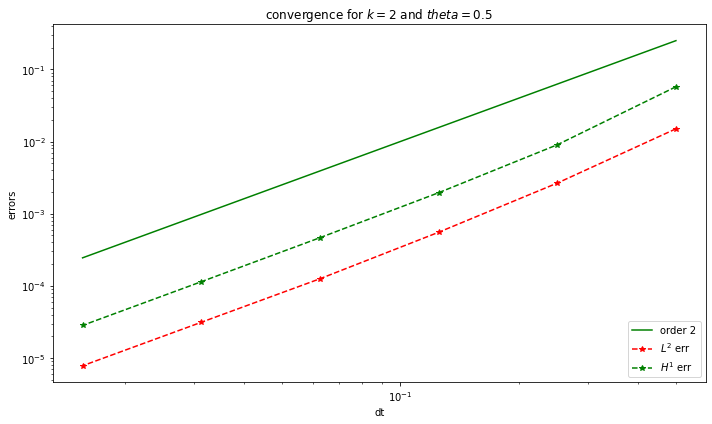

In [ ]:
# definition of the meshsize 
dt = np.array([0.5/(2**i) for i in range(6)])

# we use the subplots axis layout managers in matplotlib
fig, axes = plt.subplots(figsize=(10,6))

axes.loglog(dt, dt**2, 'g',label="order 2")
axes.loglog(dt, M_err[0,:], 'r--*',label="$L^2$ err")
axes.loglog(dt, M_err[1,:], 'g--*',label="$H^1$ err")

axes.set_title("convergence for $k=2$ and ${theta}=0.5$");
axes.set_xlabel("dt")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.tight_layout()
plt.show()